# Downloading the dataset

In [ ]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  20.3M      0  0:00:37  0:00:37 --:--:-- 21.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  7187k      0  0:00:02  0:00:02 --:--:-- 7187k


# Importing Necessory Packages


In [ ]:
import os
import random
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

In [ ]:
# Creating List of Input images and the target images
input_img_paths = []
for fname in os.listdir(input_dir):
  if (fname.endswith(".jpg")):
    input_img_paths.append(os.path.join(input_dir, fname))

input_img_paths = sorted(input_img_paths)

target_img_paths = []
for fname in os.listdir(target_dir):
  if fname.endswith(".png") and not fname.startswith("."):
    target_img_paths.append(os.path.join(target_dir, fname))

target_img_paths = sorted(target_img_paths)

In [ ]:
print("Number of samples:", len(input_img_paths))
for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


In [ ]:
# Creating the Training set and the Validation Set
c = random.randint(3000,5000)
train_input_p = []
train_target_p = []
val_input_p = []
val_target_p = []
val_size = int(0.2*len(input_img_paths))

for i in range(len(input_img_paths)):
  if (i<c or i>=c+val_size):
    train_input_p.append(input_img_paths[i])
    train_target_p.append(target_img_paths[i])
  else:
    val_input_p.append(input_img_paths[i])
    val_target_p.append(target_img_paths[i])

In [ ]:
# Ceeating the Image Array
x = np.zeros((len(train_input_p),img_size[0], img_size[1], 3),dtype = "float32")
y = np.zeros((len(train_target_p), img_size[0],img_size[1],1),dtype = "uint8")
for i in range(len(train_input_p)):
  x[i] = np.divide(load_img(train_input_p[i], target_size=img_size),255.0)
  img = load_img(train_target_p[i], target_size = img_size, color_mode="grayscale")
  y[i] = np.expand_dims(img, 2)
  y[i] -= 1

In [ ]:
# Creating and Defining the Model 
from tensorflow.keras import layers
def model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))


    x = layers.Conv2D(32, 4, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x 


    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  
        previous_block_activation = x

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)


        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  
        previous_block_activation = x  

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)


    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()


model = model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   1568        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

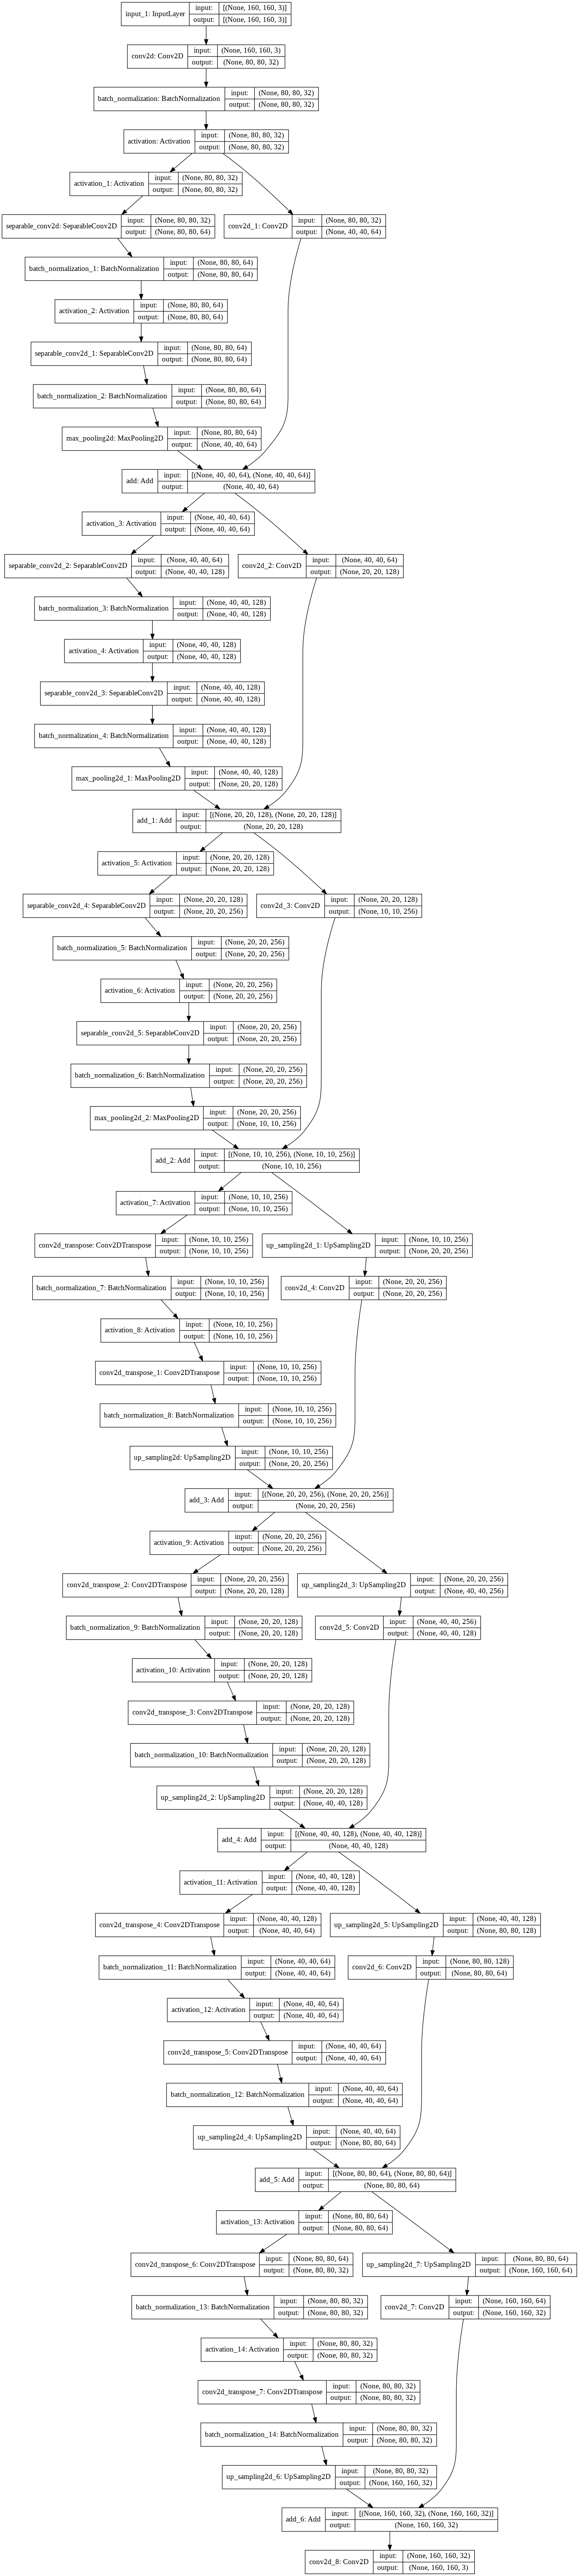

In [ ]:
# Showing the Model flow
tf.keras.utils.plot_model(model, show_shapes= True)

In [ ]:
# Compiling and Training The Model
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy",
              metrics = ['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

epochs = 25
model.fit(x,y, epochs=epochs,batch_size = batch_size, callbacks=callbacks)

Epoch 1/25
185/185 [==============================] - 78s 225ms/step - loss: 0.9961 - accuracy: 0.6957
Epoch 2/25
185/185 [==============================] - 41s 221ms/step - loss: 0.5368 - accuracy: 0.7862
Epoch 3/25
185/185 [==============================] - 42s 226ms/step - loss: 0.4572 - accuracy: 0.8189
Epoch 4/25
185/185 [==============================] - 41s 224ms/step - loss: 0.4071 - accuracy: 0.8392
Epoch 5/25
185/185 [==============================] - 42s 225ms/step - loss: 0.3712 - accuracy: 0.8538
Epoch 6/25
185/185 [==============================] - 42s 225ms/step - loss: 0.3448 - accuracy: 0.8644
Epoch 7/25
185/185 [==============================] - 41s 224ms/step - loss: 0.3157 - accuracy: 0.8751
Epoch 8/25
185/185 [==============================] - 42s 225ms/step - loss: 0.2944 - accuracy: 0.8834
Epoch 9/25
185/185 [==============================] - 42s 224ms/step - loss: 0.2747 - accuracy: 0.8911
Epoch 10/25
185/185 [==============================] - 42s 224ms/step - l

In [ ]:
# Creating the Validation Image array
val_x = np.zeros((len(val_input_p),img_size[0], img_size[1], 3),dtype = "float32")
val_y = np.zeros((len(val_target_p), img_size[0],img_size[1],1),dtype = "uint8")
for i in range(len(val_input_p)):
  val_x[i] = np.divide(load_img(val_input_p[i], target_size=img_size),255.0)
  img = load_img(val_target_p[i], target_size = img_size, color_mode="grayscale")
  val_y[i] = np.expand_dims(img, 2)
  val_y[i] -= 1

In [ ]:
# Prediction the validation set
val_pre = model.predict(val_x)
print(val_pre.shape)

(1478, 160, 160, 3)


In [ ]:
val_loss, val_acc = model.evaluate(val_x, val_y)
print("Validation Accuracy is {:0.2f} %".format(val_acc*100))

47/47 [==============================] - 3s 57ms/step - loss: 0.5249 - accuracy: 0.8454
Validation Accuracy is 84.54 %


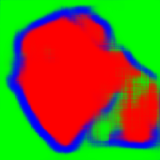

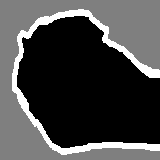

******** ###### *********


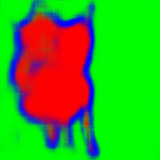

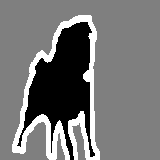

******** ###### *********


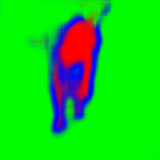

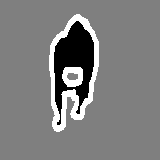

******** ###### *********


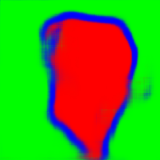

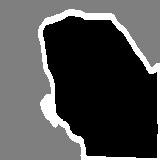

******** ###### *********


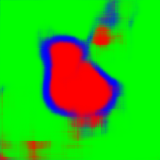

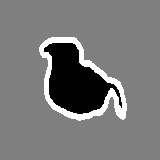

******** ###### *********


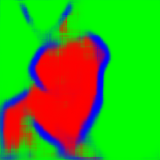

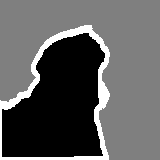

******** ###### *********


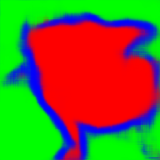

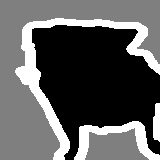

******** ###### *********


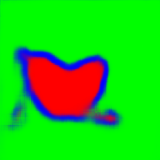

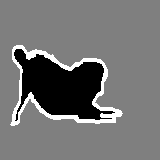

******** ###### *********


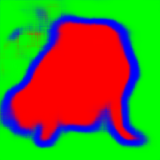

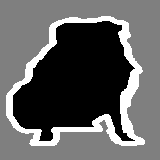

******** ###### *********


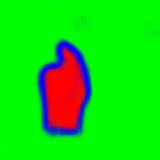

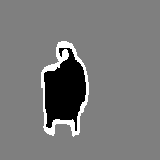

******** ###### *********


In [36]:
# Visualizing the predictions
import matplotlib.pyplot as plt
import PIL
from PIL import ImageOps

c = random.randint(0,1400)
for i in range(c,c+10):
  img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(val_pre[i]))
  display(img)

  img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(val_y[i]))
  display(img)
  print("******** ###### *********")